In [1]:
# After cleaning and preprocessing, the dataset contains 6,640 rows and 6 columns.
# The columns before cleaning and preprocessing are described below:

# UID: Unique identifier for each machine record (used only for reference, not for modeling).
# ProductID: Encodes product quality level:
  # L = Low quality (≈50%)
  # M = Medium quality (≈30%)
  # H = High quality (≈20%)
# Air temperature [K]: Represents the air temperature with random fluctuations.
# Process temperature [K]: Generated from a baseline temperature combined with random noise.
# Rotational speed [rpm]: Average power output around 2860 rpm with some predictable variation.
# Torque [Nm]: Mechanical torque centered around 40 Nm with variation of ±10 Nm.
# Machine failure: Binary target variable either (0 or 1) indicating failure occurrence when any of the failure mode gets active.

In [2]:
# pip install -U imbalanced-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection & evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [4]:
# Step 1: Data Cleaning
df = pd.read_csv('Predictive_Maintenance_Uncleaned_Dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10815 entries, 0 to 10814
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      9973 non-null   float64
 1   Product_ID               9973 non-null   object 
 2   Type                     9973 non-null   object 
 3   Air_temperature [K]      9973 non-null   float64
 4   Process_temperature [K]  9973 non-null   float64
 5   Rotational_speed [rpm]   9973 non-null   float64
 6   Torque [Nm]              9973 non-null   float64
 7   Tool_wear [min]          9973 non-null   float64
 8   Target                   9973 non-null   float64
 9   Failure_Type             9973 non-null   object 
dtypes: float64(7), object(3)
memory usage: 845.1+ KB


In [6]:
df.shape

(10815, 10)

In [7]:
df = df.dropna(how = 'all').dropna().drop_duplicates()

In [8]:
df

,UDI,Product_ID,Type,Air_temperature [K],Process_temperature [K],Rotational_speed [rpm],Torque [Nm],Tool_wear [min],Target,Failure_Type
0,4610.0,L51789,L,303.0,311.2,1456.0,44.0,142.0,0.0,No Failure
1,6886.0,L54065,L,300.8,311.2,1397.0,48.7,111.0,0.0,No Failure
2,4875.0,L52054,L,303.8,312.5,1619.0,30.9,142.0,0.0,No Failure
3,653.0,L47832,L,297.7,309.2,1391.0,44.5,159.0,0.0,No Failure
4,8464.0,M23323,M,298.7,309.9,1411.0,45.1,51.0,0.0,No Failure
...,...,...,...,...,...,...,...,...,...,...
10810,9402.0,M24261,M,297.7,308.2,1720.0,25.6,174.0,0.0,No Failure
10811,4010.0,L51189,L,302.2,311.2,1630.0,36.0,169.0,0.0,No Failure
10812,5929.0,M20788,M,300.2,310.1,1550.0,38.7,45.0,0.0,No Failure
10813,4157.0,M19016,M,302.0,310.5,1823.0,25.1,87.0,0.0,No Failure


In [9]:
df.isnull().sum()

UDI                        0
Product_ID                 0
Type                       0
Air_temperature [K]        0
Process_temperature [K]    0
Rotational_speed [rpm]     0
Torque [Nm]                0
Tool_wear [min]            0
Target                     0
Failure_Type               0
dtype: int64

In [10]:
df.columns

Index(['UDI', 'Product_ID', 'Type', 'Air_temperature [K]',
       'Process_temperature [K]', 'Rotational_speed [rpm]', 'Torque [Nm]',
       'Tool_wear [min]', 'Target', 'Failure_Type'],
      dtype='object')

In [11]:
df = df.drop(columns = ['UDI', 'Failure_Type', 'Product_ID']) # Product_ID represents the product quality category. Product_ID column was deleted due to the problem of overfitting.

In [12]:
df

,Type,Air_temperature [K],Process_temperature [K],Rotational_speed [rpm],Torque [Nm],Tool_wear [min],Target
0,L,303.0,311.2,1456.0,44.0,142.0,0.0
1,L,300.8,311.2,1397.0,48.7,111.0,0.0
2,L,303.8,312.5,1619.0,30.9,142.0,0.0
3,L,297.7,309.2,1391.0,44.5,159.0,0.0
4,M,298.7,309.9,1411.0,45.1,51.0,0.0
...,...,...,...,...,...,...,...
10810,M,297.7,308.2,1720.0,25.6,174.0,0.0
10811,L,302.2,311.2,1630.0,36.0,169.0,0.0
10812,M,300.2,310.1,1550.0,38.7,45.0,0.0
10813,M,302.0,310.5,1823.0,25.1,87.0,0.0


In [13]:
df = df.dropna()

In [14]:
df

,Type,Air_temperature [K],Process_temperature [K],Rotational_speed [rpm],Torque [Nm],Tool_wear [min],Target
0,L,303.0,311.2,1456.0,44.0,142.0,0.0
1,L,300.8,311.2,1397.0,48.7,111.0,0.0
2,L,303.8,312.5,1619.0,30.9,142.0,0.0
3,L,297.7,309.2,1391.0,44.5,159.0,0.0
4,M,298.7,309.9,1411.0,45.1,51.0,0.0
...,...,...,...,...,...,...,...
10810,M,297.7,308.2,1720.0,25.6,174.0,0.0
10811,L,302.2,311.2,1630.0,36.0,169.0,0.0
10812,M,300.2,310.1,1550.0,38.7,45.0,0.0
10813,M,302.0,310.5,1823.0,25.1,87.0,0.0


In [15]:
df.columns

Index(['Type', 'Air_temperature [K]', 'Process_temperature [K]',
       'Rotational_speed [rpm]', 'Torque [Nm]', 'Tool_wear [min]', 'Target'],
      dtype='object')

In [16]:
df.to_csv('Final_Cleaned_Predictive_Maintenance_Dataset.csv', index = False, encoding = 'utf-8')

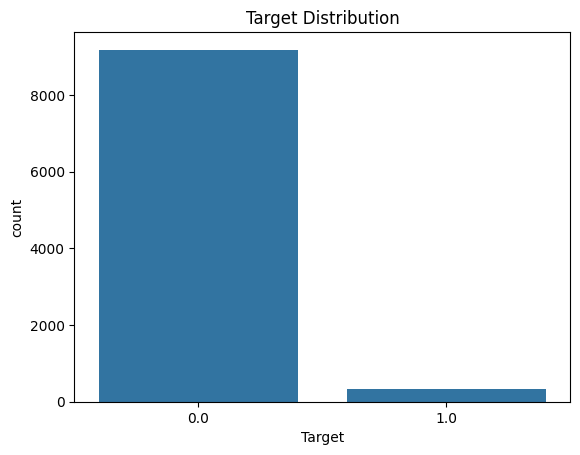

In [17]:
# Step 2: Performing the Exploratory Data Analytics
sns.countplot(x = 'Target', data = df)
plt.title("Target Distribution")
plt.show()

In [18]:
# Step 3: Encoded the Categorical columns i.e. Type and Target (Fixes the String Error)
# 'L' => 0, 'H' => 1 i.e. Performed Label Encoding
le_type = LabelEncoder()
le_target = LabelEncoder()

In [19]:
df['Type'] = le_type.fit_transform(df['Type'])
print("Encoded rows sample:", df['Type'].head().tolist())  # Should be [1,1,1,...] no 'L'

Encoded rows sample: [1, 1, 1, 1, 2]


In [20]:
df['Target'] = le_target.fit_transform(df['Target'])
print("Target: ", df['Target'].value_counts())

Target:  Target
0    9178
1     322
Name: count, dtype: int64


In [21]:
# Step 4: Seperate Features(x) and Target(y)
x = df.drop('Target', axis = 1) 
y = df['Target']

In [22]:
# Step 5: Performing train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.30, random_state = 42, stratify = y) # stratify = y is important for imbalance.

In [23]:
print(f"Train shape: {xtrain.shape}, Test shape: {xtest.shape}")

Train shape: (6650, 6), Test shape: (2850, 6)


In [24]:
# Identifying the type of the column
numerical_features = x.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = x.select_dtypes(include = ['object']).columns

In [25]:
# Step 6: Used to check whether the data is leaking or not.

# SMOTE is applied only on the training dataset to avoid leakage)
smote = SMOTE(random_state = 42)
xtrain_balanced, ytrain_balanced = smote.fit_resample(xtrain, ytrain)

print(f"Original train: {ytrain.value_counts().to_dict()}")
print(f"Balanced train: {pd.Series(ytrain_balanced).value_counts().to_dict()}")

Original train: {0: 6425, 1: 225}
Balanced train: {0: 6425, 1: 6425}


In [26]:
# Step 7: Feature(Input) Scaling
numerical_columns = ['Air_temperature [K]', 'Process_temperature [K]', 'Rotational_speed [rpm]', 'Torque [Nm]', 'Tool_wear [min]']
scaler = StandardScaler()

In [27]:
# Fitting only on the training data
xtrain[numerical_columns] = scaler.fit_transform(xtrain[numerical_columns])

# Transform test data using the training mean / std(Standard Deviation)
xtest[numerical_columns] = scaler.transform(xtest[numerical_columns])

In [28]:
print("Datatypes of Input columns are:", x.dtypes)  # All should be float64 / int64
print(x.head())

Datatypes of Input columns are: Type                         int64
Air_temperature [K]        float64
Process_temperature [K]    float64
Rotational_speed [rpm]     float64
Torque [Nm]                float64
Tool_wear [min]            float64
dtype: object
   Type  Air_temperature [K]  Process_temperature [K]  Rotational_speed [rpm]  \
0     1                303.0                    311.2                  1456.0   
1     1                300.8                    311.2                  1397.0   
2     1                303.8                    312.5                  1619.0   
3     1                297.7                    309.2                  1391.0   
4     2                298.7                    309.9                  1411.0   

   Torque [Nm]  Tool_wear [min]  
0         44.0            142.0  
1         48.7            111.0  
2         30.9            142.0  
3         44.5            159.0  
4         45.1             51.0  


In [29]:
# Column Transformer(Used for Safer Processing)
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', LabelEncoder(), categorical_features)
    ]
)

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000),
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(random_state = 42),
    "SVM": SVC(probability = True, random_state = 42),
    "KNN": KNeighborsClassifier()
}

In [31]:
# Building the Pipeline for each model.
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps = [
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state = 42)),
        ('model', model)
    ])

In [32]:
# Stratified KFolds Setup.
cv = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = 42
)

In [33]:
# Baseline Model Comparison(Without Tuning)
baseline_results = {}

for name, pipe in pipelines.items():
    scores = []
    
    for train_index, val_index in cv.split(xtrain, ytrain):
        X_train_1 = xtrain.iloc[train_index]
        X_val_1 = xtrain.iloc[val_index]
        Y_train_1 = ytrain.iloc[train_index]
        Y_val_1 = ytrain.iloc[val_index]
        
        pipe.fit( X_train_1,  Y_train_1)
        pred = pipe.predict(X_val_1)
        scores.append(f1_score(Y_val_1, pred))
    
    baseline_results[name] = np.mean(scores)

baseline_results

{'Logistic Regression': np.float64(0.24582967640645287),
 'Decision Tree': np.float64(0.5203372623682561),
 'Random Forest': np.float64(0.6595386423295647),
 'SVM': np.float64(0.41305102972046176),
 'KNN': np.float64(0.4231302929583249)}

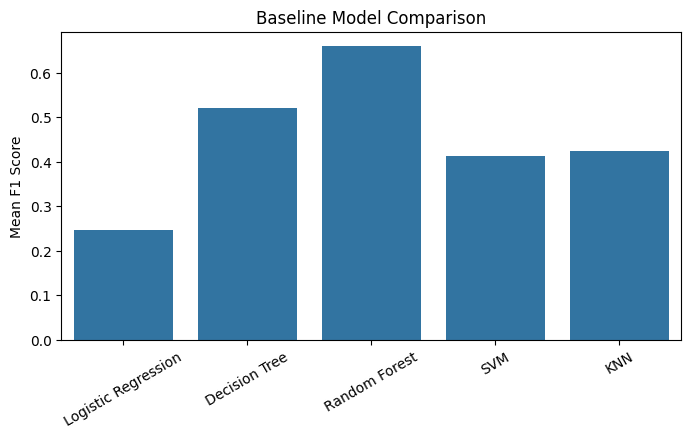

In [34]:
# Baseline Model's Performance Comparison Visualization

plt.figure(figsize = (8,4))
sns.barplot(
    x = list(baseline_results.keys()),
    y = list(baseline_results.values())
)
plt.ylabel("Mean F1 Score")
plt.xticks(rotation = 30)
plt.title("Baseline Model Comparison")
plt.show()

In [35]:
# Hyperparameter Tuning with GridSearchCV(With Pipeline)

# Random Forest Tuning:

rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    pipelines['Random Forest'],
    param_grid = rf_param_grid,
    scoring = 'f1',
    cv = cv,
    n_jobs = -1
)

rf_grid.fit(xtrain, ytrain)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold

In [36]:
# SVM Tuning:

svm_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf']
}

svm_grid = GridSearchCV(
    pipelines['SVM'],
    param_grid = svm_param_grid,
    scoring = 'f1',
    cv = cv,
    n_jobs = -1
)

svm_grid.fit(xtrain, ytrain)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__C': [0.1, 1, ...], 'model__kernel': ['linear', 'rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : 

In [37]:
# KNN Tuning:

knn_param_grid = {
    'model__n_neighbors': [3,5,7,9],
    'model__weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(
    pipelines['KNN'],
    param_grid = knn_param_grid,
    scoring = 'f1',
    cv = cv
)

knn_grid.fit(xtrain, ytrain)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__n_neighbors': [3, 5, ...], 'model__weights': ['uniform', 'distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is 

In [38]:
# Results of all the models that have been tuned

tuned_results = {
    "Random Forest": rf_grid.best_score_,
    "SVM": svm_grid.best_score_,
    "KNN": knn_grid.best_score_
}

tuned_results

{'Random Forest': np.float64(0.6595386423295647),
 'SVM': np.float64(0.4773138560176429),
 'KNN': np.float64(0.43720826040596367)}

In [39]:
# Final Model Selection & Training

best_model = rf_grid.best_estimator_

In [40]:
# Final Evaluation on the test data

y_pred = best_model.predict(xtest)

print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2753
           1       0.59      0.78      0.67        97

    accuracy                           0.97      2850
   macro avg       0.79      0.88      0.83      2850
weighted avg       0.98      0.97      0.98      2850



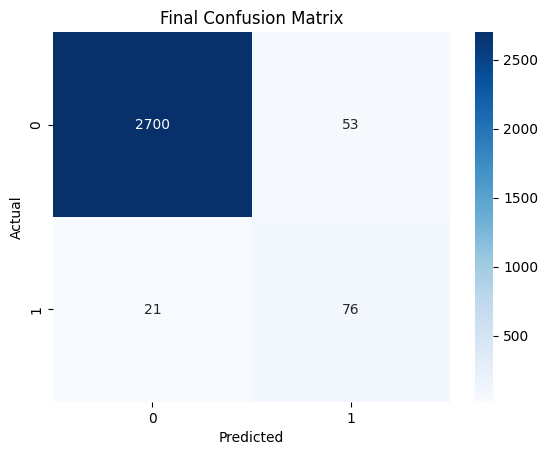

In [41]:
# Confusion Matrix

cm = confusion_matrix(ytest, y_pred)

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix")
plt.show()

In [42]:
# Leakage Detection Test(For Safer Side)

y_shuffled = ytrain.sample(frac = 1, random_state = 42)

best_model.fit(xtrain, y_shuffled)
shuffled_pred = best_model.predict(xtest)

print(classification_report(ytest, shuffled_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2753
           1       0.02      0.03      0.03        97

    accuracy                           0.92      2850
   macro avg       0.49      0.49      0.49      2850
weighted avg       0.93      0.92      0.93      2850

